In [1]:
import sys; import importlib
import time
import numpy as np
# importlib.reload(sys.modules['dipy_custom_imwarp'])
sys.path.append('/Users/elliottunstall/Desktop')
sys.path.append('/Users/elliottunstall/Desktop/Imperial/FYP/codebase/utils')
from segmentation_toolkit import Mask, Segmentation
from useful_functions import load_inputs, show_image
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt
import mat73
from metrics_evaluation import metrics_evaluation

from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric as SSD
from dipy.viz import regtools
from dipy_custom_imwarp.dipy2.align.imwarp import SymmetricDiffeomorphicRegistration as custom_reg
from dipy_custom_imwarp.dipy2.align.metrics import SSDMetric as SSD2

from dipy.align.imaffine import AffineMap, MutualInformationMetric, AffineRegistration


/opt/anaconda3/envs/FYP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/FYP/lib/python3.11/site-packages/dipy/viz/__init__.py:22: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(


['/Users/elliottunstall/Desktop/Imperial/FYP/codebase/testing', '/opt/anaconda3/envs/FYP/lib/python311.zip', '/opt/anaconda3/envs/FYP/lib/python3.11', '/opt/anaconda3/envs/FYP/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/FYP/lib/python3.11/site-packages', '/Users/elliottunstall/Desktop', '/Users/elliottunstall/Desktop/Imperial/FYP/codebase/utils', '/Users/elliottunstall/Desktop/Imperial/FYP/codebase/venv/segmentation-mask-overlay', '/Users/elliottunstall/Desktop/dipy_custom_imwarp']
['/Users/elliottunstall/Desktop/Imperial/FYP/codebase/testing', '/opt/anaconda3/envs/FYP/lib/python311.zip', '/opt/anaconda3/envs/FYP/lib/python3.11', '/opt/anaconda3/envs/FYP/lib/python3.11/lib-dynload', '', '/opt/anaconda3/envs/FYP/lib/python3.11/site-packages', '/Users/elliottunstall/Desktop', '/Users/elliottunstall/Desktop/Imperial/FYP/codebase/utils', '/Users/elliottunstall/Desktop/Imperial/FYP/codebase/venv/segmentation-mask-overlay', '/Users/elliottunstall/Desktop/dipy_custom_imwarp', '/User

2024-05-13 16:05:39.559606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fixed, moving, pxm = load_inputs(70)
seg_fixed = Segmentation(fixed)
seg_moving = Segmentation(moving)
seg_fixed.kmeans(mrf=0.15)
seg_fixed.apply_smoothing(method='morph_closing')
seg_moving.kmeans(mrf=0.15)
seg_moving.apply_smoothing(method='morph_closing')
seg_fixed.masks['tissue'] = [seg_fixed.masks['tissue'][0]]
seg_fixed.masks['background'] = [seg_fixed.masks['background'][1], seg_fixed.masks['background'][2]]
seg_moving.masks['tissue'] = [seg_moving.masks['tissue'][0]]
seg_moving.masks['background'] = [seg_moving.masks['background'][1], seg_moving.masks['background'][2]]

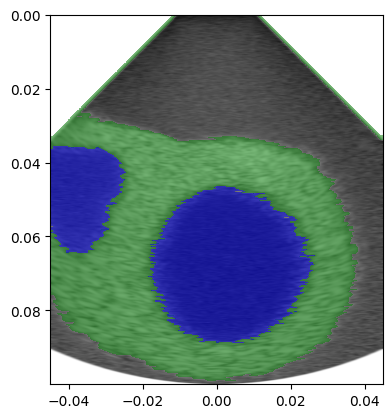

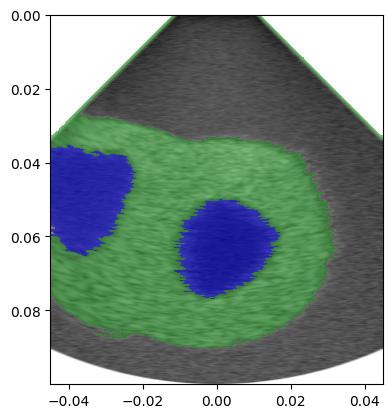

In [3]:
seg_fixed.show(pixelMap = pxm, overlay_image=True, alpha=0.5)
seg_moving.show(pixelMap = pxm, overlay_image=True, alpha=0.5)
moving_mask = seg_moving.masks['tissue'][0].mask
fixed_mask = seg_fixed.masks['tissue'][0].mask

In [4]:
# affine = AffineRegistration(metric=SSD(2))
# moving_mapping = affine.optimize(fixed, moving)
# moving_mask_mapping = affine.optimise(fixed_mask, moving_mask)
# moving1 = moving_mapping.transform(moving)
# moving2 = moving_mask_mapping.transform(moving)
# moving_mask2 = moving_mask_mapping.transform(moving_mask)

194.57671299999998


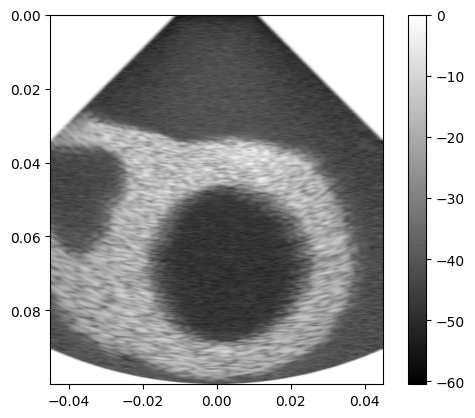

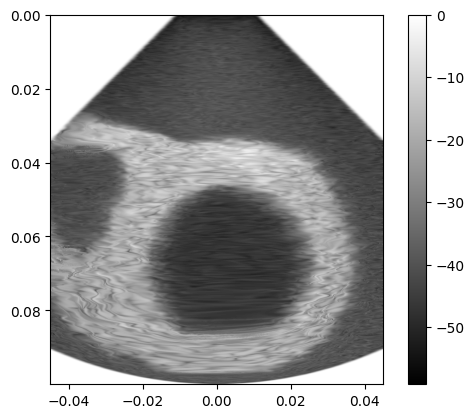

In [5]:
## Testing dipy

algorithm = SymmetricDiffeomorphicRegistration(metric=SSD(2), level_iters=[44, 44, 44, 44, 44, 44, 44], ss_sigma_factor=0.1818, opt_tol=0.001041168)
                                                       
start_time = time.process_time()
mapping = algorithm.optimize(fixed.astype(float), moving.astype(float))
execution_time = time.process_time() - start_time

deform_forward1 = mapping.forward
deform_backward1 = mapping.backward
output_image1 = mapping.transform(moving, 'linear')

print(execution_time)
show_image(fixed, pxm)
show_image(output_image1, pxm)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map')

# regtools.overlay_images(fixed, output_image, 'Static', 'Overlay',
#                              'Warped moving',)

In [6]:
print(np.shape(moving.astype(float)))
print(np.shape(seg_fixed.masks['tissue'][0].mask.astype(float)))

(2952, 334)
(2952, 334)


130.165141


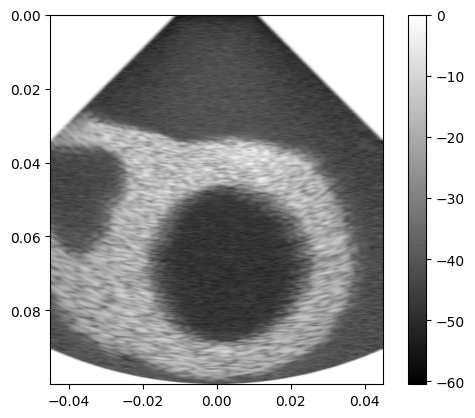

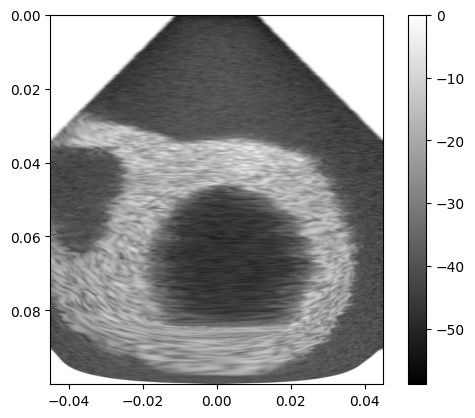

In [7]:
## Testing custom dipy

algorithm = custom_reg(metric=SSD2(2), level_iters=[44, 44, 44, 44, 44, 44, 44], 
                       ss_sigma_factor=0.1818, opt_tol=0.001041168)
                                                       
start_time = time.process_time()
mapping = algorithm.optimize(fixed.astype(float), moving.astype(float),
                              seg_fixed.masks['tissue'][0].mask.astype(float),
                              seg_moving.masks['tissue'][0].mask.astype(float))
execution_time = time.process_time() - start_time

deform_forward2 = mapping.forward
deform_backward2 = mapping.backward
output_image2 = mapping.transform(moving, 'linear')

print(execution_time)
show_image(fixed, pxm)
show_image(output_image2, pxm)

# regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map')
# regtools.overlay_images(fixed, output_image, 'Static', 'Overlay',
#                          'Warped moving',)

2757554.2


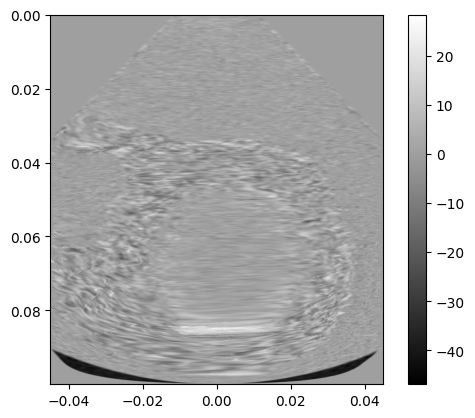

In [8]:
print(np.sum(abs(output_image2-output_image1)))
show_image(output_image2-output_image1, pxm)

In [9]:
errors = metrics_evaluation(output_image1, fixed, moving, execution_time, "1-50_cardiac", '/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/')
errors_custom = metrics_evaluation(output_image2, fixed, moving, execution_time, "1-50_cardiac_custom", '/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/')

In [10]:
print(errors)
print(errors_custom)

[[ 7.96849000e+06  8.57703916e-02]
 [ 9.50198746e+00  8.57703919e-02]
 [ 1.28917252e+00  3.06797463e+00]
 [ 7.62769106e-01  1.41655138e+00]
 [ 9.69750016e-01  1.61112970e+00]
 [-2.30958042e+03 -2.85554726e-04]]
[[ 2.27839900e+07  2.45239907e-01]
 [ 2.71686573e+01  2.45239893e-01]
 [ 8.98853806e-01  2.13909358e+00]
 [ 5.99860344e-01  1.11401077e+00]
 [ 9.08089945e-01  1.50868849e+00]
 [-3.01518402e+03 -2.24567244e-04]]


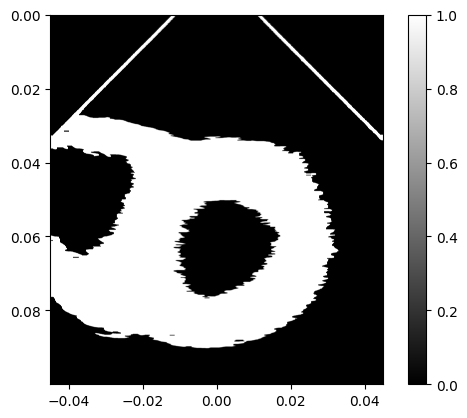

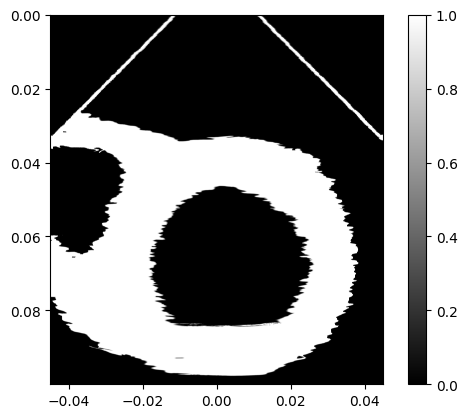

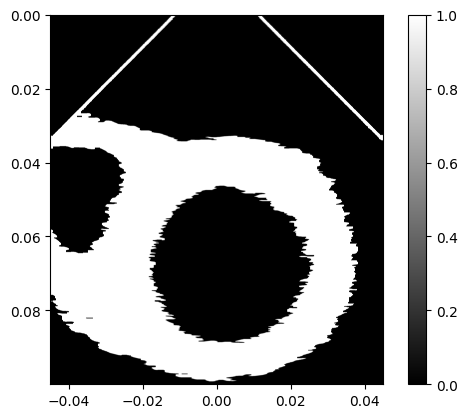

In [11]:
show_image(seg_moving.masks["tissue"][0].mask, pxm)
show_image(mapping.transform(seg_moving.masks['tissue'][0].mask, 'linear'), pxm)
show_image(seg_fixed.masks["tissue"][0].mask, pxm)

In [12]:

deform_forward1 = deform_forward1 * 0.0001  
deform_backward1 = deform_backward1 * 0.0001
deform_forward2 = deform_forward2 * 0.0001  
deform_backward2 = deform_backward2 * 0.0001

# -------------------------- Generate ground truths -------------------------- #
def generate_ground_truth(deform_forward, deform_backward, pxm, slice1, slice2):
    pts0 = loadmat(f'/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/eval_pts_{slice1}.mat')['pts']
    pts50 = loadmat(f'/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/eval_pts_{slice2}.mat')['pts']
    # pxm = loadmat('/Users/elliottunstall/Desktop/Imperial/FYP/Example_cardiac_dataset/bmode_f1.mat')['pixelMap']
    print(pts0[0,0])
    pts0[:,2] = pts0[:,2] - 0.0045
    pts50[:,2] = pts50[:,2] - 0.0045

    x = pxm['X']
    z = pxm['Z']
    y = pxm['Y']

    newpts = np.zeros(pts0.shape)

    for i in range(pts0.shape[0]):
    # Forward
        print(x)
        print(pts0[i,0])
        xind = np.where(np.abs(x - pts0[i,0]) == min(np.abs(x - pts0[i,0])))
        zind = np.where(np.abs(z - pts0[i,2]) == min(np.abs(z - pts0[i,2])))
        dx = deform_forward[zind,xind,1]
        dz = deform_forward[zind,xind,0]

        newpts[i,0] = pts0[i,0] + dx
        newpts[i,1] = pts0[i,2] + dz
    
    # Backward
        xind = np.where(np.abs(x - pts50[i,0]) == min(np.abs(x - pts50[i,0])))
        zind = np.where(np.abs(z - pts50[i,2]) == min(np.abs(z - pts50[i,2])))
        dx = deform_backward[zind,xind,1]
        dz = deform_backward[zind,xind,0]

        newpts[i,2] = pts50[i,0] + dx
        newpts[i,3] = pts50[i,2] + dz

    # ------------------------------ Calculate error ----------------------------- #
    ae = np.zeros([pts0.shape[0], 4])
    ae[:,0] = pts0[:,0] - newpts[:,0]       # forward, x-axis
    ae[:,1] = pts0[:,2] - newpts[:,1]       # forward, z-axis
    ae[:,2] = pts50[:,0] - newpts[:,2]       # backward, x-axis
    ae[:,3] = pts50[:,2] - newpts[:,3]       # backward, z-axis
    
    return pts0,newpts, ae

original_pts1, newpts1, error1 = generate_ground_truth(deform_forward1, deform_backward1, pxm, 0, 50)
original_pts2, newpts2, error2 = generate_ground_truth(deform_forward2, deform_backward2, pxm, 0, 50)


-0.05919249934241266
[[array([[-4.500e-02, -4.473e-02, -4.446e-02, -4.419e-02, -4.392e-02,
          -4.365e-02, -4.338e-02, -4.311e-02, -4.284e-02, -4.257e-02,
          -4.230e-02, -4.203e-02, -4.176e-02, -4.149e-02, -4.122e-02,
          -4.095e-02, -4.068e-02, -4.041e-02, -4.014e-02, -3.987e-02,
          -3.960e-02, -3.933e-02, -3.906e-02, -3.879e-02, -3.852e-02,
          -3.825e-02, -3.798e-02, -3.771e-02, -3.744e-02, -3.717e-02,
          -3.690e-02, -3.663e-02, -3.636e-02, -3.609e-02, -3.582e-02,
          -3.555e-02, -3.528e-02, -3.501e-02, -3.474e-02, -3.447e-02,
          -3.420e-02, -3.393e-02, -3.366e-02, -3.339e-02, -3.312e-02,
          -3.285e-02, -3.258e-02, -3.231e-02, -3.204e-02, -3.177e-02,
          -3.150e-02, -3.123e-02, -3.096e-02, -3.069e-02, -3.042e-02,
          -3.015e-02, -2.988e-02, -2.961e-02, -2.934e-02, -2.907e-02,
          -2.880e-02, -2.853e-02, -2.826e-02, -2.799e-02, -2.772e-02,
          -2.745e-02, -2.718e-02, -2.691e-02, -2.664e-02, -2.637e-02,

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()